In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf

In [10]:
a=np.array([1,2,3])
b=np.array([4,5,6,7])
print(np.outer(a,b))
print(np.sum(np.outer(a,b),axis=0))

[[ 4  5  6  7]
 [ 8 10 12 14]
 [12 15 18 21]]
[24 30 36 42]


In [11]:
dt = 0.2
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 1000000

In [12]:
# generate steps for all particles
steps=np.random.normal(loc=0.0, scale=2*D*dt, size=(N,length))

In [13]:
# initial positions
x = 2*L*np.random.random(size=(N,))

In [14]:
# put initial position in front
x = np.column_stack((x, steps))

In [15]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),2*L)-L

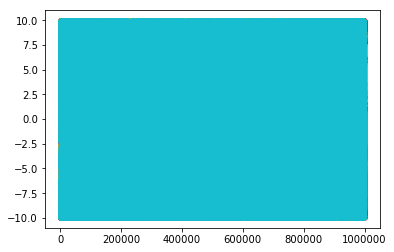

In [16]:
for path in paths:
    plt.plot(path,".")

In [17]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=0)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

0.996439350175
1.0


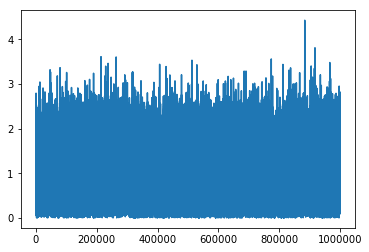

In [18]:
plt.plot(intensity)
print(intensity.mean())
# what should it be
print(N/2/L)

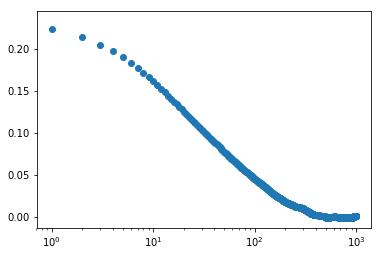

In [19]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:1000]-1.0
t = np.arange(0,autocorr.size)
plt.semilogx(t,autocorr,"o")

In [20]:
print(autocorr[0]/N*L)
print(L/autocorr[0]/N)
print(autocorr[0]*N/L*2*np.sqrt(np.pi))
print(L/autocorr[0]/N/np.sqrt(np.pi))

0.117212784614
2.13287314028
1.66203401171
1.20334480877


In [21]:
# this is the model that describes the ideal case if infinite boundary conditions
def corrfit(s,N,D,gamma,w0):
    return 1/N/(1+(D*dt*s/w0**2))**gamma

In [62]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(s,N,D,w0,L):
    nmax = 20
    n = np.arange(0,nmax)
    efa = n*np.pi*w0**2*1j
    an = np.exp(-n**2*np.pi**2*w0**2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an2 = an**2/L
    an2[0]=an2[0]/2
    t=s*dt
    at = np.exp(-D*t)
    a2mat = np.outer(an2,at)
    return np.sum(a2mat,axis=0)/N

In [59]:
corrfitPB_model=lm.Model(corrfitPB)
paramsPB = corrfitPB_model.make_params()
paramsPB['w0'].set(value=1,vary=False)
paramsPB['N'].set(value=20,vary=True)
paramsPB['D'].set(value=1,vary=True)
paramsPB['L'].set(value=L,vary=False)

resultPB = corrfitPB_model.fit(s=t,data=autocorr,params=paramsPB)

In [60]:
print(resultPB.fit_report())

[[Model]]
    Model(corrfitPB)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 2000
    # variables        = 1
    chi-square         = 0.800
    reduced chi-square = 0.000
    Akaike info crit   = -15645.712
    Bayesian info crit = -15640.111
[[Variables]]
    N:    2.19487986 +/- 0.069339 (3.16%) (init= 20)
    D:    1 (fixed)
    w0:   1 (fixed)
    L:    10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)



In [23]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=1,vary=False)
params['N'].set(value=5,vary=True)
params['D'].set(value=1,vary=True)
params['gamma'].set(value=0.5,vary=False)

result = corrfit_model.fit(s=t,data=autocorr,params=params)

In [24]:
print(result.fit_report())

[[Model]]
    Model(corrfit)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 1000
    # variables        = 2
    chi-square         = 0.252
    reduced chi-square = 0.000
    Akaike info crit   = -8279.683
    Bayesian info crit = -8269.868
[[Variables]]
    N:       3.36926990 +/- 0.154475 (4.58%) (init= 5)
    D:       3.15606125 +/- 0.339406 (10.75%) (init= 1)
    gamma:   0.5 (fixed)
    w0:      1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.935 



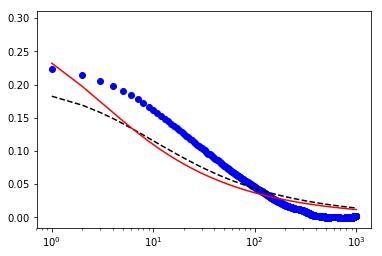

In [25]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


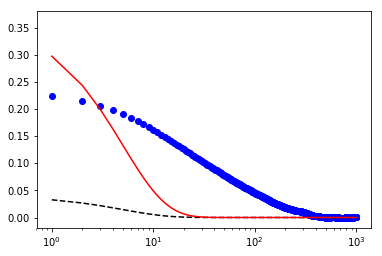

In [61]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, resultPB.init_fit, 'k--')
plt.semilogx(t, resultPB.best_fit, 'r-')